# **combine the aa and codon into one heatmap**

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import numpy as np 
import json
import pandas as pd
from datetime import datetime

In [2]:
SynonymousCodons = {'CYS': ['TGT', 'TGC'], 'ASP': ['GAT', 'GAC'],
'SER': ['TCT', 'TCG', 'TCA', 'TCC', 'AGC', 'AGT'],
'GLN': ['CAA', 'CAG'], 'MET': ['ATG'], 'ASN': ['AAC', 'AAT'],
'PRO': ['CCT', 'CCG', 'CCA', 'CCC'], 'LYS': ['AAG', 'AAA'],
'STOP': ['TAG', 'TGA', 'TAA'], 'THR': ['ACC', 'ACA', 'ACG', 'ACT'],
'PHE': ['TTT', 'TTC'], 'ALA': ['GCA', 'GCC', 'GCG', 'GCT'],
'GLY': ['GGT', 'GGG', 'GGA', 'GGC'], 'ILE': ['ATC', 'ATA', 'ATT'],
'LEU': ['TTA', 'TTG', 'CTC', 'CTT', 'CTG', 'CTA'], 'HIS': ['CAT', 'CAC'],
'ARG': ['CGA', 'CGC', 'CGG', 'CGT', 'AGG', 'AGA'], 'TRP': ['TGG'],
'VAL': ['GTA', 'GTC', 'GTG', 'GTT'], 'GLU': ['GAG', 'GAA'], 'TYR': ['TAT', 'TAC']}
get_aa_dict = {}#dictionary that turns codon into aa 
for key,value in SynonymousCodons.items(): 
    for codon in value: 
        get_aa_dict[codon] = key 

bases = [ "T", "C","A", "G"]

In [4]:
#reading in dfs
codon_change_df = pd.read_csv("data/dif_DNA/2021_04_18_codon_propChnage_2xcov.csv")
aa_change_df = pd.read_csv("data/dif_DNA/2021_04_18_aa_propChnage_2xcov.csv")

In [7]:
#making the list of mean chnage counts for each triplet in the order for "triplets" 
codon_aa_meanChangeCount_array = []
for base1 in bases: 

    for base3 in bases:
        curr_codon_counts_list = []
        
        for base2 in bases: 
            curr_codon = base1+base2+base3
            curr_codon_counts_list.append(float(np.mean(codon_change_df[[curr_codon]])))
            cur_aa = get_aa_dict[curr_codon]
            curr_codon_counts_list.append(float(np.mean(aa_change_df[[cur_aa]])))
        codon_aa_meanChangeCount_array.append(curr_codon_counts_list)
    

# **getting on the plotting**

In [8]:
plt.style.use("seaborn-darkgrid")

In [9]:
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, codon_meanChangeCount_array, start=0,  stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    
    cmap_counts = []
    for value in codon_meanChangeCount_array: 
        cmap_counts.extend(value)

    cmapmax = max(cmap_counts)
    cmapmin = min(cmap_counts)
    
    midpoint = 1 - cmapmax/(cmapmax - cmapmin)
    
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(start, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, stop, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

In [10]:
base2_axis = []
base1base3_axis = []
for base13 in bases: 
    base2_axis.append("_"+base13+"_")
    for base2 in bases: 
        base1base3_axis.append(base13+"_"+base2)

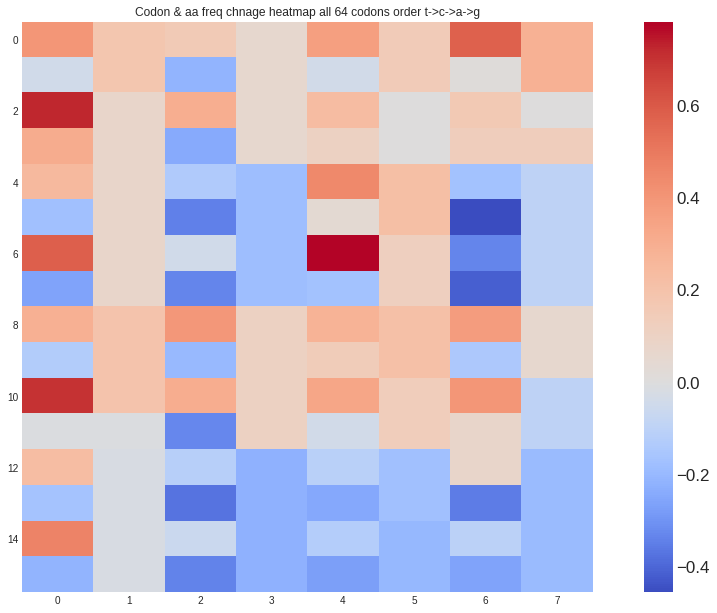

In [11]:
fig, ax = plt.subplots()
im = ax.imshow(np.array(codon_aa_meanChangeCount_array), interpolation="nearest", cmap = shiftedColorMap(matplotlib.cm.coolwarm, codon_aa_meanChangeCount_array), aspect =1/2)

# We want to show all ticks...
# ax.set_xticks(np.arange(len(base2_axis)))
# ax.set_yticks(np.arange(len(base1base3_axis)))
# ... and label them with the respective list entries
# ax.set_xticklabels(base2_axis)
# ax.set_yticklabels(base1base3_axis)

# Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor")

# for i in range(len(base1base3_axis)):
#     for j in range(len(base2_axis)):
#         text = ax.text(j, i, np.array(codon_meanChangeCount_array)[i, j],
#                        ha="center", va="center", color="k")


ax.grid(False)
ax.set_title("Codon & aa freq chnage heatmap all 64 codons order t->c->a->g")
#fig.tight_layout()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)

fig.colorbar(im).ax.tick_params(labelsize=17)
plt.show()